<a href="https://colab.research.google.com/github/Morteza-Kazemi/PubMedVision-NLP-Project/blob/main/PubMedVision_NLP_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Briefly describing the data

### Dataset Introduction

PubMedVision is a large-scale medical VQA dataset. We extracted high-quality image-text pairs from PubMed and used GPT-4V to reformat them to enhance their quality. PubMedVision significantly improves the multimodal capabilities of MLLMs in the medical field.

PubMedVision contains 1.3 million medical VQAs, divided (equally) into Alignment VQA and Instruction Tuning VQA:
- Alignment VQA: focuses on grounding the model's understanding between medical images and corresponding questions, ensuring accurate visual-textual associations.
- Instruction Tuning VQA: trains the model to follow natural language prompts and generate context-aware, expert-level medical answers.

We pick InstructionTuning_VQA and analyze it. It consists of medical image-based conversations structured for instruction tuning*.

\* Instruction tuning is a method where language models are trained not just on raw text, but on question–answer pairs or tasks framed as instructions. The goal is to make models more responsive, helpful, and aligned with how users interact with them in real-world tasks — like answering questions.

PubMedVision is based on this paradigm. It contains:

- A question or prompt (e.g., “What does the arrow in the image indicate?”)
- A detailed GPT-4V-generated answer describing the medical image



Each entry includes:

 - An image (file path, not used directly in this phase)

- A conversation consisting of:

 - A question (from a human)

 - A GPT-4V-generated answer (image caption/interpretation)

- Metadata:

 - modality (e.g., CT, MRI, X-ray)

 - body_part (e.g., Chest, Brain, Abdomen)

This dataset was originally created to train vision-language models (multimodal) to respond to questions about medical images. However, in this project, we focus on the textual side, treating the GPT-generated answers as natural language documents.

### Setup and basic stats
loading the dataset, sample size, random samples, missing values, word count distribution, etc

In [1]:
# Setup

# Install Huggingface Datasets and Transformers
!pip install -U datasets transformers --quiet

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
import random

# Basic Configs
pd.set_option('display.max_colwidth', 200)  # wider display for long texts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_ma

In [2]:
# Load PubMedVision dataset with the correct config
dataset = load_dataset(
    "FreedomIntelligence/PubMedVision",
    name="PubMedVision_InstructionTuning_VQA",
    split="train",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

PubMedVision_InstructionTuning_VQA.json:   0%|          | 0.00/722M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/646759 [00:00<?, ? examples/s]

In [3]:
# Convert to DataFrame
df = pd.DataFrame(dataset)

# Show basic info
print(f"Sample size: {len(df)}")
print(df.columns)

# Display a few random examples
df.sample(5)

Sample size: 646759
Index(['image', 'conversations', 'id', 'modality', 'body_part'], dtype='object')


,image,conversations,id,modality,body_part
486009,[images/pmc_486010_0.jpg],"[{'from': 'human', 'value': 'What does this lesion mean for my family member's health, and what are our next steps?'}, {'from': 'gpt', 'value': 'The lesion identified in the MRI is an intradural, ...",Instruction-Tuning_486010,Magnetic Resonance Imaging,Brain
179673,[images/pmc_179674_0.jpg],"[{'from': 'human', 'value': 'What types of gastrointestinal conditions are mentioned in the image?'}, {'from': 'gpt', 'value': 'The image mentions a variety of gastrointestinal conditions, includi...",Instruction-Tuning_179674,Digital Photography,Gastrointestinal tract
564549,"[images/pmc_564550_0.jpg, images/pmc_564550_1.jpg, images/pmc_564550_2.jpg, images/pmc_564550_3.jpg, images/pmc_564550_4.jpg]","[{'from': 'human', 'value': 'I noticed some colored regions and bands in my colon tissue images. Can you explain what these represent?'}, {'from': 'gpt', 'value': 'Sure! The colored regions you se...",Instruction-Tuning_564550,Microscopy Images,Others
396303,[images/pmc_396304_0.jpg],"[{'from': 'human', 'value': 'What medical interventions were used to treat the patient's severe COVID-19 ARDS?'}, {'from': 'gpt', 'value': 'According to the reference information, the patient was ...",Instruction-Tuning_396304,Computed Tomography,Chest
129292,[images/pmc_129293_0.jpg],"[{'from': 'human', 'value': 'What is the diameter of the largest volume of interest (VOI) shown in the image?'}, {'from': 'gpt', 'value': 'The diameter of the largest volume of interest (VOI1) sho...",Instruction-Tuning_129293,Computed Tomography,Lower limb


In [4]:
# Extract question and answer cleanly

# Helper function to extract 'human' and 'gpt' parts
def extract_conversation_parts(conv_list):
    question = ""
    answer = ""
    for item in conv_list:
        if item['from'] == 'human':
            question = item['value']
        elif item['from'] == 'gpt':
            answer = item['value']
    return question, answer

# Apply to create new columns
df[['question', 'answer']] = df['conversations'].apply(lambda x: pd.Series(extract_conversation_parts(x)))

# Drop the old 'conversations' column (not needed anymore)
df.drop(columns=['conversations'], inplace=True)

# Quick check
df[['question', 'answer', 'modality', 'body_part']].sample(5)


,question,answer,modality,body_part
4779,What is the relationship between the middle colic artery (MCA) and the right gastro-omental artery (RGOA) in this image?,"According to the reference information provided, the right gastro-omental artery (RGOA) arose from the middle colic artery (MCA) in this case. This relationship between the RGOA and MCA is an impo...",Computed Tomography,Abdomen
306852,家属: 请问这张超声图片显示的是什么？我的家人有什么问题？,医生: 这张图是颈部区域的超声波图像，主要显示了颈动脉和迷走神经的位置。颈动脉是供血到头部和脖子的主要血管之一，而迷走神经则是控制身体许多重要功能的神经。在这张图片中，迷走神经位于颈动脉的外侧下方。这种位置关系是正常的，迷走神经并没有异常信号，暂时没有发现您家人的具体疾病。这样的检查通常用于诊断神经和血管是否有异常压迫或其他病变。如果有特定的症状，我们还需要进一步进行其他检查来确定原因。,Ultrasound,Upper limb
468756,"Based on the image of Panel B, what protein could be intensely expressed in these renal cells and why might its detection be crucial in diagnosing specific types of renal cell carcinomas?","The protein intensely expressed, as shown in Panel B, appears to be cathepsin K, evident from the dense, homogenous brown staining throughout the cells. Detecting cathepsin K is crucial in diagnos...",Microscopy Images,Cell
51891,"What do the findings in the CT scan suggest, and what could be the potential cause of these abnormalities?","The findings in the CT scan suggest the presence of a moderate right-sided pleural effusion, which could be due to various underlying conditions, such as infection, malignancy, or an inflammatory ...",Computed Tomography,Chest
112805,I noticed there are metal rods and screws in images E and F; what do they do?,The metal rods and screws you see in the images are used in spinal fusion surgeries to help stabilize and support the spine. They hold the vertebrae in place while the bone graft heals and fuses t...,Computed Tomography,Others


In [5]:
# Basic Dataset Stats

# How many samples do we have?
print(f"Total samples: {len(df)}")

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic description
df[['question', 'answer']].describe()


Total samples: 646759

Missing values per column:
image        0
id           0
modality     0
body_part    0
question     0
answer       0
dtype: int64


,question,answer
count,646759,646759
unique,604731,646693
top,What type of medical imaging technique is used in this image?,The medical imaging modality used in this image is magnetic resonance imaging (MRI). MRI is a non-invasive imaging technique that uses strong magnetic fields and radio waves to generate detailed i...
freq,991,5



Question Lengths (words):
count    646759.000000
mean         21.606674
std          13.282360
min           1.000000
25%          14.000000
50%          19.000000
75%          27.000000
max         975.000000
Name: question_word_count, dtype: float64

Answer Lengths (words):
count    646759.000000
mean         96.110704
std          38.456630
min           1.000000
25%          75.000000
50%          95.000000
75%         114.000000
max         798.000000
Name: answer_word_count, dtype: float64


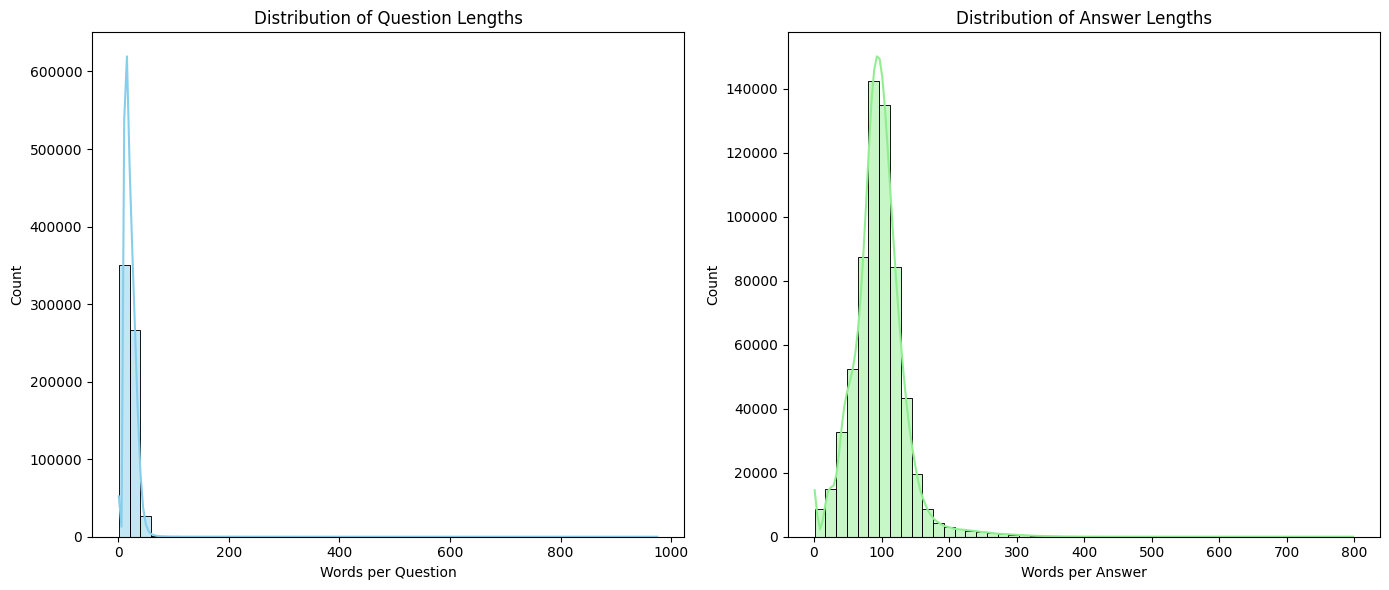

In [6]:
# Analyze text lengths

# Helper function: count words
def word_count(text):
    return len(text.split())

# Add word count columns
df['question_word_count'] = df['question'].apply(word_count)
df['answer_word_count'] = df['answer'].apply(word_count)

# Basic stats
print("\nQuestion Lengths (words):")
print(df['question_word_count'].describe())

print("\nAnswer Lengths (words):")
print(df['answer_word_count'].describe())

# Plot the distributions
plt.figure(figsize=(14, 6))

# Questions
plt.subplot(1, 2, 1)
sns.histplot(df['question_word_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Words per Question')

# Answers
plt.subplot(1, 2, 2)
sns.histplot(df['answer_word_count'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Words per Answer')

plt.tight_layout()
plt.show()

### vocabulary, top words, vocabulary size distribution

In [ ]:
# Vocabulary and Frequent Words

from collections import Counter
import re

# Helper simple tokenizer (simple split + remove punctuation)
def simple_tokenize(text):
    # Lowercase, remove non-letters, split
    tokens = re.findall(r'\b\w+\b', text.lower()) #\w matches ASCII characters: [A-Za-z0-9_]
    return tokens

# Tokenize all texts
question_tokens = df['question'].apply(simple_tokenize)
answer_tokens = df['answer'].apply(simple_tokenize)

# Flatten lists
all_question_words = [word for tokens in question_tokens for word in tokens]
all_answer_words = [word for tokens in answer_tokens for word in tokens]

# Vocabulary size
print(f"Vocabulary size in Questions: {len(set(all_question_words))}")
print(f"Vocabulary size in Answers: {len(set(all_answer_words))}")

# Top 20 frequent words
print("\nTop 20 words in Questions:")
print(Counter(all_question_words).most_common(20))

print("\nTop 20 words in Answers:")
print(Counter(all_answer_words).most_common(20))

# 100 least common words
print("\nLeast common 100 words in Questions:")
print(Counter(all_question_words).most_common()[-100:])

print("\nLeast common 100 words in Answers:")
print(Counter(all_answer_words).most_common()[-100:])

- we see words in greek characters like "σ1". Latin characters are meaningfull in the medical context so we need to add them to our vocabulary even if it's only a single greek letter.

- we see many strange chinese characters like "我看到这张图里有一个螺丝样的器械在髋部" with a very low frequency (1) so we are going to remove those.

- also for the sake of our analysis, numbers (e.g. 1234 and not IL_6) do not mean very much as vocabulary so we will also remove those.

- the top 20 words are mostly stop words which doesn't imply much meaning. So, we will remove them to see the top 20 meaningful words in our vocabulary.

In [ ]:
# we need to free-up the colab RAM

import gc

# we're done using them
question_tokens, answer_tokens, all_question_words, all_answer_words = None, None, None, None

# Manually trigger garbage collection
gc.collect()

In [ ]:
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Unicode ranges:
# Latin:     \u0041–\u007A (A–z, including lowercase)
# Extended:  \u00C0–\u00FF (accents), \u0100–\u017F (Latin Extended-A)
# Greek:     \u0370–\u03FF

# Regex: keep only tokens made of Latin, Greek, or digits (optional underscores)
TOKEN_PATTERN = re.compile(r'\b[\u0041-\u007A\u00C0-\u00FF\u0100-\u017F\u0370-\u03FF0-9_]+\b', re.UNICODE)

def clean_tokenize(text):
    tokens = TOKEN_PATTERN.findall(text.lower())
    cleaned = [tok for tok in tokens if not tok.isdigit()]  # remove pure numbers
    return cleaned

# Apply tokenizer
question_tokens = df['question'].apply(clean_tokenize)
answer_tokens = df['answer'].apply(clean_tokenize)

# Flatten
all_question_words = [word for tokens in question_tokens for word in tokens]
all_answer_words = [word for tokens in answer_tokens for word in tokens]

# Vocabulary
vocab_question = set(all_question_words)
vocab_answer = set(all_answer_words)

print(f"Vocabulary size in Questions (Latin+Greek): {len(vocab_question)}")
print(f"Vocabulary size in Answers (Latin+Greek): {len(vocab_answer)}")

# Frequencies
q_counter = Counter(all_question_words)
a_counter = Counter(all_answer_words)

# Top 20 (excluding stopwords)
top_q = [(w, c) for w, c in q_counter.most_common() if w not in stop_words][:20]
top_a = [(w, c) for w, c in a_counter.most_common() if w not in stop_words][:20]

print("\nTop 20 meaningful words in Questions:")
print(top_q)

print("\nTop 20 meaningful words in Answers:")
print(top_a)

# Least 100 frequent
print("\nLeast common 100 words in Questions:")
print(q_counter.most_common()[-100:])

print("\nLeast common 100 words in Answers:")
print(a_counter.most_common()[-100:])


There we go! Now we have a cleaner vocabulary.

In [ ]:
# Function to compute per-document vocabulary size (excluding stopwords)
def vocab_size_per_doc(token_lists):
    return token_lists.apply(lambda tokens: len(set(w for w in tokens if w not in stop_words)))

# Compute per-document vocab size
df['question_vocab_size'] = vocab_size_per_doc(question_tokens)
df['answer_vocab_size'] = vocab_size_per_doc(answer_tokens)

# Show summary
print("\nPer-document vocabulary size (excluding stopwords):\n")
print(df[['question_vocab_size', 'answer_vocab_size']].describe())


Interesting! But zero is the minimum.. Let's see how many zeros we have.

In [ ]:
zero_q = (df['question_vocab_size'] == 0).sum()
zero_a = (df['answer_vocab_size'] == 0).sum()

print(f"Number of questions with zero vocabulary size: {zero_q}")
print(f"Number of answers with zero vocabulary size: {zero_a}")

Hopefully they're not that many, hence causing no serious problem. So, we can skip them.

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['question_vocab_size'], bins=30, alpha=0.7, label='Questions')
plt.hist(df['answer_vocab_size'], bins=30, alpha=0.7, label='Answers')
plt.xlabel("Vocabulary Size (per document)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Per-Document Vocabulary Size Distribution")
plt.show()

## Playing around with documents

### Clustering

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Tokenizer based on previous policy: lowercase, split on hyphen, keep underscores
def medical_tokenizer(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Vectorize the questions
vectorizer = TfidfVectorizer(
    tokenizer=medical_tokenizer,
    min_df=5,           # ignore rare words
    max_features=3000,  # cap vocab size to control sparsity
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(df['question'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF matrix shape: (646759, 3000)


KMeans Clustering on Question Vectors

We apply KMeans clustering to group questions potentially into **10 clusters**, corresponding to the 10 most common imaging modalities in the dataset.

Assuming each cluster could represent a set of semantically similar questions, potentially tied to *Modality*-specific language


In [8]:
from sklearn.cluster import KMeans

# Number of clusters based on number of modalities
num_clusters = 10

# Run KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['question_cluster'] = kmeans.fit_predict(X_tfidf)

# Check distribution
print("Samples per cluster:")
print(df['question_cluster'].value_counts().sort_index())


Samples per cluster:
question_cluster
0     35739
1     10758
2     31626
3     88538
4     94901
5     26026
6     18836
7     52445
8    259672
9     28218
Name: count, dtype: int64


- **Cluster 8** is by far the largest, containing over 250K questions. This suggests it may represent:
  - General-purpose or “template-like” question phrasing
  - Common patterns such as “What does this show?”, “Can you explain...?”
- Clusters **1**, **6**, and **9** are much smaller, which may indicate:
  - Niche topics, distinct language styles or edge cases
- The rest are fairly balanced and support interpretable semantic groupings.

While some size variation is expected in unsupervised clustering, the relative consistency (aside from cluster 8) shows that question text alone already provides meaningful separability.


In [16]:
from sklearn.metrics import silhouette_score

# Inertia: Sum of squared distances to cluster centers
print(f"Inertia: {kmeans.inertia_:.2f}")


Inertia: 588924.80


- Lower inertia generally indicates **tighter, more compact clusters**
- However, it tends to **decrease with more clusters**, so it is not useful on its own to assess clustering quality unless used in an "elbow curve" comparison
- We report inertia here for completeness, but our **primary evaluation** comes from analyzing cluster content and its alignment with modality as our assumption.


Visualizing Clusters in 2D (SVD)

To visualize the structure of clusters, we reduce the TF-IDF vectors to 2 dimensions using Truncated SVD (a PCA-like method for sparse data).

(PCA crashes due to severe ram usage)

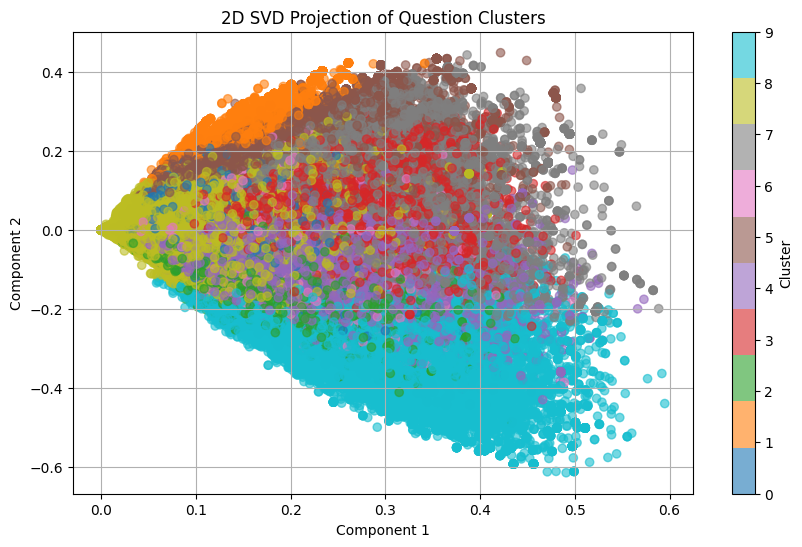

In [9]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reduce dimensionality without densifying the matrix
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['question_cluster'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("2D SVD Projection of Question Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


To qualitatively interpret each cluster, let's sample a few representative questions from each one.

In [10]:
# Show a few questions per cluster to interpret themes
for cluster_id in range(num_clusters):
    print(f"\n\n🔹 Cluster {cluster_id}")
    print("=" * 60)
    samples = df[df['question_cluster'] == cluster_id]['question'].sample(3, random_state=cluster_id)
    for i, q in enumerate(samples):
        print(f"\nExample {i+1}: {q}")




🔹 Cluster 0

Example 1: What types of cells are present in the tumor lesion based on the immunohistochemical staining?

Example 2: I noticed there are arrows pointing to certain cells in the biopsy image of my abdominal rash. What do these cells represent and should I be concerned about them?

Example 3: What type of staining method is used to identify the amyloid deposits in the liver tissue?


🔹 Cluster 1

Example 1: What type of imaging modality is used in this image?

Example 2: What type of medical imaging technique is used to capture this image?

Example 3: What type of imaging modality is used in this study?


🔹 Cluster 2

Example 1: I'm looking at the ultrasound results you've shown me, and I'm concerned about what the intensity factor is. Can you explain why this matter for my health?

Example 2: Doctor, could you explain the changes observed in the MRI images before and after treatment?

Example 3: I'm worried that the electrode in my brain might cause damage. How safe is i

Top Terms per Cluster (Centroid Inspection)

We can see the important terms for each cluster by inspecting the centroid vector for the cluster. Let's have a look at the terms with high weights in the centroid of the each cluster.

These terms help us understand the dominant vocabulary that defines each group.

In [11]:
# Get vocabulary terms
vocab = vectorizer.get_feature_names_out()


# Print top terms from each cluster centroid
top_n = 10  # top N words to show

print("📌 Top terms by cluster centroid:\n")

for i in range(num_clusters):
    print(f"\n🔹 Cluster {i} (Top {top_n} terms):")
    print("-" * 40)
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    top_terms = [vocab[j] for j in sorted_terms[:top_n]]
    print(", ".join(top_terms))


📌 Top terms by cluster centroid:


🔹 Cluster 0 (Top 10 terms):
----------------------------------------
staining, cells, image, patterns, images, observed, tissue, based, does, indicate

🔹 Cluster 1 (Top 10 terms):
----------------------------------------
used, imaging, type, technique, modality, medical, capture, image, obtain, acquire

🔹 Cluster 2 (Top 10 terms):
----------------------------------------
m, doctor, explain, worried, results, really, images, concerned, mean, sure

🔹 Cluster 3 (Top 10 terms):
----------------------------------------
based, potential, clinical, findings, provided, images, implications, diagnosis, observed, significance

🔹 Cluster 4 (Top 10 terms):
----------------------------------------
does, mean, image, indicate, noticed, areas, different, condition, represent, colors

🔹 Cluster 5 (Top 10 terms):
----------------------------------------
type, image, shown, tissue, visible, medical, depicted, tumor, histological, mri

🔹 Cluster 6 (Top 10 terms):
------

looks like each of the clusters contains relatively consistent terms. e.g. cluster0 has key terms: cells, tissue, patterns which relate to microscopic images. cluster0 has ct-scans, cluster 8 has MRI, etc. We will later interpret these more comprehensively.


To evaluate how meaningful the clusters are, let's cross-tabulate each question cluster with the actual `modality` label (from image metadata).

This reveals whether clusters capture:
- Modality-specific language (e.g., “CT”, “X-ray”)
- Or structural/intent-based language (e.g., “What does this mean?”, “Doctor, I'm worried...”)

let's see how much clusters aligned with the modalities which was our initial assumption.

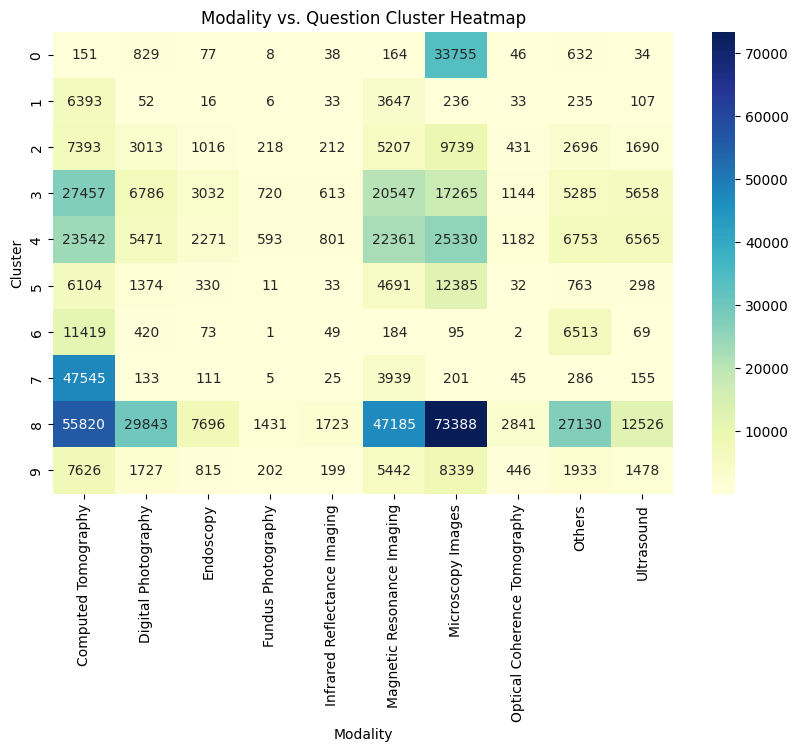

In [15]:
import pandas as pd

# Focus on top 10 most frequent modalities
top_modalities = df['modality'].value_counts().nlargest(10).index
filtered_df = df[df['modality'].isin(top_modalities)]

# Cross-tabulate: cluster vs modality
modality_cluster_table = pd.crosstab(filtered_df['question_cluster'], filtered_df['modality'])

# Show table
# print("🔍 Modality distribution across clusters:")
# print(modality_cluster_table)

# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(modality_cluster_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Modality vs. Question Cluster Heatmap")
plt.xlabel("Modality")
plt.ylabel("Cluster")
plt.show()


### Cluster Evaluation Summary: Questions vs Modality

To evaluate the quality of our question-based clustering, we examined:
1. **Top terms** from each cluster's centroid (TF-IDF weights)
2. **Sample questions** from each cluster
3. **Modality distribution** across clusters (via heatmap)

This triangulation allowed us to validate how well clusters captured meaningful structure in the data.

---

#### Highlights and Insights from the heatmap and cluster top terms

| Cluster | Theme | Evidence |
|--------|-------------------------------|---------------------------|
| 0 | **Microscopy** | “Staining”, “cells”, “patterns” → almost entirely microscopy modality |
| 1 | **Imaging Modality Identification** | Generic phrasing like “what type of modality...” → spread mostly across imaging types CT and MRI|
| 2 | **Patient Concerns / Personal Queries** | Emotional framing (“worried”, “explain”) → weak modality alignment |
| 3 | **Clinical Interpretation** | Diagnostic reasoning and clinical implications → high in CT, MRI and microscopy |
| 4 | **Meaning & Visual Feature Interpretation** | “What does this mean?” questions → modality-neutral |
| 5 | **Tumor Typing / Visible Abnormalities** | “Type”, “tumor”, “visible”, “MRI” → strong in imaging tasks - MRI, CT, Microscopy |
| 6 | **Chest X-ray Analysis** | “X-ray”, “chest”, “finding” → strong lexical and modality alignment |
| 7 | **CT-based Interpretation** | “CT”, “scan” → clearly clustered by modality |
| 8 | **Template or Broad Explanation Requests** | Generic, General-purpose or “template-like” questions → highly mixed modalities |
| 9 | **Family Health Queries** | “family”, "member", “condition”, "explain" → personal/family focused |

---

#### 📌 Conclusions

- Some clusters are tightly aligned with specific **modalities** (e.g., CT, X-ray, microscopy)
- Others capture **linguistic style** or **functional roles** of questions (e.g., concern, inquiry, interpretation)
- This confirms that unsupervised clustering on question text alone can recover both **clinical semantics** and **communication intent**
- Cluster 8 stands out as a **stylistic or template-driven group**, while clusters like 0, 6, 7 show **strong modality correlation**

This demonstrates that even without using image data or answers, the language of medical questions carries enough signal to produce meaningful groupings.


### New Section

In [ ]:
# Phase 1 - Step 10: Simple keyword search

# Build inverted index (word → list of row indices)
from collections import defaultdict

inverted_index = defaultdict(set)

for idx, answer in enumerate(df['answer']):
    tokens = simple_tokenize(answer)
    for token in tokens:
        if token not in stop_words:
            inverted_index[token].add(idx)

# Simple search function
def keyword_search(query, top_k=5):
    query = query.lower()
    matches = inverted_index.get(query, [])
    print(f"\n🔍 Found {len(matches)} result(s) for keyword: '{query}'")
    for i, idx in enumerate(list(matches)[:top_k]):
        print(f"\nResult {i+1}:\n{df.iloc[idx]['answer'][:500]}...")

# Example usage:
keyword_search("tumor")



🔍 Found 612 result(s) for keyword: 'tumor'

Result 1:
In the CT images presented, major TCCI shows a pronounced invasion with clear damages extending through both the inner and outer cortices of the cartilage, resulting in a significantly altered structural appearance. This extensive invasion categorizes it as T4 in tumor staging for laryngeal tumors, as per the AJCC 7th edition staging manual. On the other hand, minor TCCI demonstrates limited invasion confined mainly to the inner cortex, evident from the minimal disruption seen on the CT scan. Th...

Result 2:
The MRI image reveals a significant mass extending beyond the right parametrium to the pelvic wall, indicating recurrent cervical cancer. The tumor's borders are irregular, and it appears to compress surrounding structures. Notably, there is displacement of adjacent tissues, which suggests invasive behavior. The involvement of the pelvic wall is critical for staging and treatment planning, as it may affect surgical options and

In [ ]:
keyword_search("lesion")
keyword_search("bone")
keyword_search("ultrasound")


🔍 Found 441 result(s) for keyword: 'lesion'

Result 1:
The spindle-shaped morphology combined with the presence of bizarre nuclei and frequent mitoses in image B suggests a high degree of cellular atypia and disorganization typical of malignant tumors. These characteristics, especially the high mitotic rate, often indicate aggressive neoplastic growth, pointing towards a possible diagnosis of a high-grade malignancy. The necrosis and hemorrhage visible in image A also support the aggressive nature of the lesion, as these features commonly occur in r...

Result 2:
The red arrows in the images point to a cystic lesion located at the fifth lumbar (L5) nerve root and particularly in the foraminal area, as observed in the lumbar spine's MRI. The cystic appearances, indicated by hyperintense areas, suggest an accumulation of fluid or other material, which can cause pressure on adjacent nerve roots and spinal structures. This pressure can lead to symptoms such as pain, numbness, or weakness 

In [ ]:
keyword_search("does_our_project_lack_anything?")


🔍 Found 0 result(s) for keyword: 'does_our_project_lack_anything?'


try to fine-tune pretrained models